# K-means algorithm

## Algorithm

We rely heavily on the Expectation - Maximization method.

- Start with a multidimensional unlabeled dataset
- Standardization of the dataset
- Guess k cluster centers
- E-step : assign points to the closest cluster center
- Calculate the means of the newly created clusters
- M-step : set the k cluster centers to the corresponding means
- Repeat until k cluster centers and means converge

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

plt.rcParams['figure.figsize'] = (20, 8)

In [4]:
data = pd.read_csv('kmeans.csv', index_col='Unnamed: 0')

In [5]:
# standardisation du dataset
scaler = StandardScaler()
X = scaler.fit_transform(data)

## KMeans object

In [6]:
import math

class Custom_KMeans:
    
    def __init__(self, n_clusters = 2, n_init = 10, tolerance = 0.01, plot = True):
        self.inertia_ = None
        self.n_clusters_ = n_clusters
        self.tolerance = tolerance
        self.n_init = n_init
        self.predictions_ = []
        self.cluster_centers_ = []
        self.distances = None
        self.plot = plot
        
    def define_clusters_centers(self, data):
        """
        get random cluster centers
        """
        cluster_centers = []
        datasize = data.shape[0]
        cluster_centers = np.array([data[random.choice(range(datasize))] for i in range(self.n_clusters_)])
        
        return cluster_centers
    
    @staticmethod
    def get_euclidean_distance(a, b):
        """
        compute the Euclidean distance
        """
        euclidean_distance = math.sqrt(sum((a - b)**2))
        return euclidean_distance

    def get_closest_cluster(self, point, centers):
        """
        compute the cluster label for a point + distance
        """
        # we get the cluster label and the distance => to compute inertia later on
        distances = np.apply_along_axis(self.get_euclidean_distance, 1, centers, point)
        return np.where(distances == np.amin(distances))[0][0], np.amin(distances)

    def get_clusters(self, data, centers):
        """
        get new clusters
        """
        # get label for each datapoint
        predictions_distances = np.apply_along_axis(self.get_closest_cluster, 1, data, centers)
        predictions = predictions_distances[:, 0]
        distances = predictions_distances[:, 1]
    
        # sort datapoints by cluster labels
        clusters = {}

        for label, coord in zip(predictions, data):
            if label not in clusters.keys():
                clusters[label] = [] # initialize cluster list
            clusters[label].append(coord)
    
        sorted_clusters =  {k: np.array(clusters[k]) for k in sorted(clusters)}
    
        return predictions, distances, sorted_clusters
        
    @staticmethod
    def get_means_clusters(clusters):
        """
        compute the new centroids
        """
        means = []
        for key in clusters :
            moy = np.mean(clusters[key], 0)
            means.append(moy)
        return np.array(means)
    
    @staticmethod
    def color_generator():
        """
        get a random color (HEX)
        """
        color = '#'
        for i in range(6):
            color += str(random.choice('0123456789abcdef'))
        return color
    
    @staticmethod
    def plot_clusters(data, predictions, centroids, colors):
        """
        plot the current state of the kmeans algorithm
        """
        fig, ax = plt.subplots()
        sns.scatterplot(x=data[:, 0], y=data[:,1], hue=predictions, ax=ax)
        for i in range(len(centroids)):
            plt.scatter(centroids[i, 0], centroids[i, 1], marker='D', s=200, c=colors[i])
    
    def fit(self, data):
        """
        get the optimum centroids
        """
        # since we are doing several iterations of the algo to get a global optimum,
        # we need to store the result for each iteration
        means = []
        inertias = []
        predictions_list = []
    
        for i in range(self.n_init):
            # Guess k random cluster centers
            centers = self.define_clusters_centers(data)
            cluster_means = np.empty((2, 2))
            colors = [self.color_generator() for j in range(len(centers))]

            while True :
                # Expectation step : assign points to the closest cluster center
                predictions, distances, clusters = self.get_clusters(data, centers)
                
                if self.plot and i == 0:
                    # display different phase of the algorithm for the first iteration
                    self.plot_clusters(data, predictions, centers, colors)

                cluster_means = self.get_means_clusters(clusters)
                
                if np.array_equal(cluster_means, centers) or np.abs(cluster_means - centers).all() < self.tolerance: 
                    # converge
                    break
                else :
                    # Maximisation step : set the k cluster centers to the new means
                    centers = cluster_means

            # get results for the current iteration
            means.append(cluster_means)
            predictions_list.append(predictions)
            inertias.append(np.sum(distances))
        
        # get the global optimum : has the lowest intertia
        self.inertia_ = min(inertias) # get the lowest inertia to get the corresponding centroids and predictions
        index_best_clusters = inertias.index(self.inertia_)
        self.cluster_centers_ = means[index_best_clusters]
        self.predictions = predictions_list[index_best_clusters]
    
    def fit_predict(self, data):
        """
        get the new centroids, cluster labels and predictions
        """
        self.fit(data)
        return self.predictions_
    
    def predict(self):
        """
        return only the cluster labels
        """
        return self.predictions_
    

In [8]:
model = Custom_KMeans(n_clusters = 2, plot = False)
model.fit_predict(X)
model.cluster_centers_

array([[-0.91670593,  0.93735114],
       [ 0.91670593, -0.93735114]])

## Kmeans Scikit-Learn

([<matplotlib.axis.YTick at 0x1a1f568b10>,
 <a list of 6 Text yticklabel objects>)

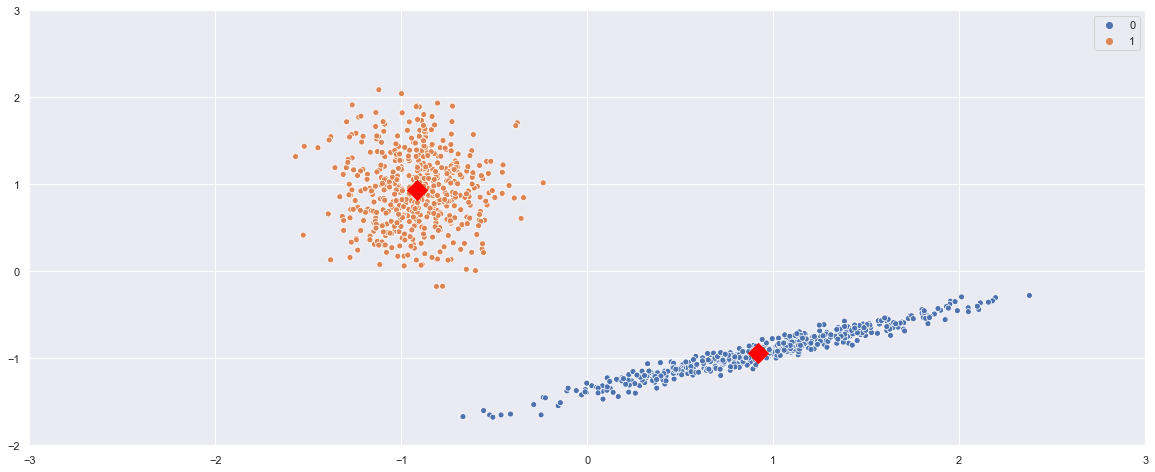

In [30]:
model = KMeans(n_clusters = 2, random_state=0, precompute_distances=True)
predictions = model.fit_predict(scaled_data)
centroids = model.cluster_centers_

sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:,1], hue=predictions)
for i in range(len(centroids)):
    plt.scatter(centroids[i, 0], centroids[i, 1], marker='D', s=200, c='red')
plt.xticks(range(-3, 4))      
plt.yticks(range(-2, 4)) 